# a spring coupled mass simulator to create positions of mechanisms and purviews of a CES 

In [1]:
import numpy as np
import math
import pickle as pkl

from pyphi import visualize as viz
from pyphi import relations as rel

import matplotlib.pyplot as plt


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [2]:
def update_position(position,force,delta):
    return -position*force*delta

def compute_force(self_position,other_positions,ks):
    return np.sum([k*(self_position-position) for k,position in zip(ks,other_positions)])
    
def get_interactions(ces,rels):
    
    separated_ces = rel.separate_ces(ces)
    N = len(ces)
    M = len(separated_ces)
    
    # denote what components each purview will be affected by 
    # first the mechanisms
    features_mechs = np.zeros((M,N))
    for i in range(N):
        features_mechs[2*i:2*i+2, i] = 1
        
    # next the relations
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    features_rels = viz.feature_matrix(rel.separate_ces(ces), rels)
    # features now contains information about any distinction or relation each purview is associated to
    # next, we exchange the 1's with phi values
    # frist for distinctions
    for i in range(M):
        features_mechs[i,:] *= separated_ces[i].phi
        
    for i in range(len(rels)):
        features_rels[:,i] *= rels[i].phi/len(rels[i].relata)
    
    # getting the interactions between constituents
    interactions = np.zeros((N+M,N+M))
    
    # filling with mechanism-purview interactions
    interactions[N:,:N] = features_mechs
    interactions[:N,N:] = np.transpose(features_mechs)
    
    # now for the purview-purview interactions
    relrel = np.zeros((M,M))
    for i,feature in enumerate(features_rels):
        for r in feature.nonzero()[0]:
            for j in features_rels[:,r].nonzero()[0]:
                if not i==j:
                    relrel[i,j] += feature[r]
                    relrel[j,i] += feature[r]
                    
    #renormalizing to have same max as mechanisms interactions
    relrel = relrel*np.max(interactions[N:,:N])/np.max(relrel)
    
    interactions[N:, N:] = relrel
    
    return interactions


def equilibriate(ks,purviews,x,y,z=None,T=100,delta=0.01):
    if z is None:
        z=np.zeros(len(x))
    for t in range(T):
        for i in purviews:
            x[i] += update_position(x[i],compute_force(x[i],x,ks[i]),delta)
            y[i] += update_position(y[i],compute_force(y[i],y,ks[i]),delta)
            z[i] += update_position(z[i],compute_force(z[i],z,ks[i]),delta)
        
    return x, y, z

def initialize_positions(ces, center=(1,1), z=0, radius=1):
    mechs = viz.regular_polygon(len(ces), center=center, angle=0, z=0, radius=radius, scale=1)
    purviews = viz.regular_polygon(2*len(ces), center=center, angle=math.pi / (len(ces)), z=0, radius=radius, scale=0.9)
    return np.array(mechs+purviews)

In [3]:
with open(r"ch3_ces.pkl", "rb") as f:
    ces = pkl.load(f)
    
with open(r"ch3_rels.pkl", "rb") as f:
    rels = pkl.load(f)
    
with open(r"ch3_subsystem.pkl", "rb") as f:
    system = pkl.load(f)

In [4]:
xyz = initialize_positions(ces)

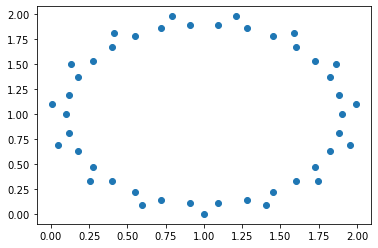

In [5]:

plt.scatter(xyz[:,0],xyz[:,1])

In [6]:
k = get_interactions(ces,rels)

In [9]:
purview_indices = tuple(range(15,45))
x,y,z = equilibriate(k,purview_indices,xyz[:,0],xyz[:,1])

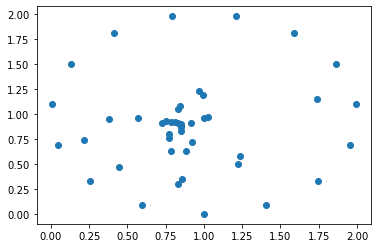

In [10]:
plt.scatter(x,y)